In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
import re
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud

In [63]:
df  = pd.read_csv("phones.csv")

In [64]:
print(df.shape)

(1349, 6)


In [65]:
df.head(5)

,description,new price,old price,rating,reviews_no,perc_discount
0,"Samsung Galaxy A20s 6.5-Inch (3GB,32GB ROM) An...","₦ 64,490","₦ 80,000",4.5 out of 5,109,19%
1,"Tecno Pouvoir 4 Pro (LC8) 7"" HD+, 4GB RAM + 64...","₦ 61,990","₦ 68,490",4.4 out of 5,26,9%
2,"UMIDIGI A7 Pro 6.3-Inch (4GB RAM,64GB ROM) And...","₦ 39,990","₦ 71,600",4.4 out of 5,445,44%
3,Gionee S11 Lite 5.7-Inch Snapdragon 430 Octa C...,"₦ 35,540","₦ 59,990",4.1 out of 5,77,40%
4,"Samsung Galaxy A31 (128GB, 4GB RAM) 6.4"" FHD +...","₦ 100,050","₦ 120,000",4.6 out of 5,48,16%


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1349 entries, 0 to 1348
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   description    1349 non-null   object
 1   new price      1349 non-null   object
 2   old price      1349 non-null   object
 3   rating         1349 non-null   object
 4   reviews_no     1349 non-null   int64 
 5   perc_discount  948 non-null    object
dtypes: int64(1), object(5)
memory usage: 63.4+ KB


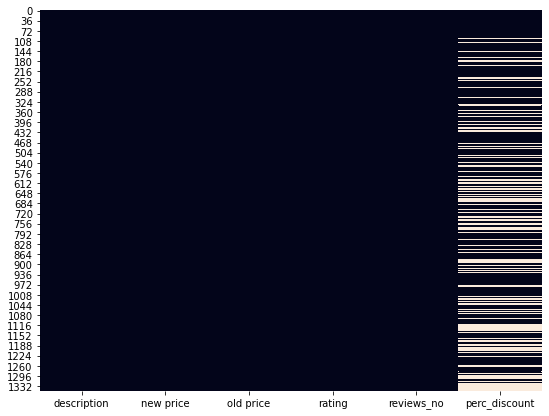

In [67]:
# visualizing missing data
fig,ax = plt.subplots(figsize = (9,7))
ax = sns.heatmap(df.isnull(), cbar=False )
plt.show()

### PREPROCESSING

In [68]:
#removing the comma and naira sign in the price columns for easy computation 
df['new price'] = df['new price'].apply(lambda x: x.replace(',',''))
df['new price'] = df['new price'].apply(lambda x: x.replace('₦ ',''))

df['old price'] = df['old price'].apply(lambda x: x.replace(',',''))
df['old price'] = df['old price'].apply(lambda x: x.replace('₦ ',''))

In [69]:
df['new price'] = df['new price'].str.split(expand=True)
df['old price'] = df['old price'].str.split(expand=True)

In [70]:
#converting the price columns to int
df[['new price', 'old price']] = df[['new price', 'old price']].astype(str).astype(int)

In [71]:
#cleaning the rating column
df['rating'] = df['rating'].str.split(pat=None, n=-1, expand=True)
df['rating'].astype(float).head()

0    4.5
1    4.4
2    4.4
3    4.1
4    4.6
Name: rating, dtype: float64

### FEATURE ENGINEERING

#### The description column contains battery size, screen size, camera quality, andriod version, ram and rom and brand which needs to be extracted

* extracting the brand from description column

In [74]:
df['brand'] = df['description'].str.split(pat=None, n=-1, expand=True)

In [75]:
df['brand'].head()

0    Samsung
1      Tecno
2    UMIDIGI
3     Gionee
4    Samsung
Name: brand, dtype: object

* creating new discount column from old price and new price


In [76]:
df['discount'] = abs((df['new price'] - df['old price'])/ df['old price'])
df['discount'] = round((df['discount'] * 100).astype(int), 0)
df.head()

,description,new price,old price,rating,reviews_no,perc_discount,brand,discount
0,"Samsung Galaxy A20s 6.5-Inch (3GB,32GB ROM) An...",64490,80000,4.5,109,19%,Samsung,19
1,"Tecno Pouvoir 4 Pro (LC8) 7"" HD+, 4GB RAM + 64...",61990,68490,4.4,26,9%,Tecno,9
2,"UMIDIGI A7 Pro 6.3-Inch (4GB RAM,64GB ROM) And...",39990,71600,4.4,445,44%,UMIDIGI,44
3,Gionee S11 Lite 5.7-Inch Snapdragon 430 Octa C...,35540,59990,4.1,77,40%,Gionee,40
4,"Samsung Galaxy A31 (128GB, 4GB RAM) 6.4"" FHD +...",100050,120000,4.6,48,16%,Samsung,16


* dropping perc_discount column as it contains lots of missing values and a new one has been created

In [77]:
df.drop(['perc_discount'], 1, inplace=True)
df.head(1)

,description,new price,old price,rating,reviews_no,brand,discount
0,"Samsung Galaxy A20s 6.5-Inch (3GB,32GB ROM) An...",64490,80000,4.5,109,Samsung,19


* extracting phone ram with regrex and storing in a new column named 'ram_gb'

In [78]:
df['ram_gb'] = df['description'].str.extract(r'(\d{,1}GB[RAM]?)', flags = re.I, expand =False)

In [79]:
df['ram_gb'].value_counts(dropna=False)

4GB     329
6GB     261
2GB     226
NaN     177
3GB     146
1GB     115
8GB      67
8gb       5
6Gb       4
2gb       3
GB        3
6GBR      3
2GBR      2
5GB       2
2Gb       2
6gb       1
1GBR      1
2gbr      1
4gb       1
Name: ram_gb, dtype: int64

In [80]:
# removing the characters
df['ram_gb'] = df['ram_gb'].str.replace("GB|gb|Gb|R|r|GBR|gbr","",case=False)
df.head(3)

,description,new price,old price,rating,reviews_no,brand,discount,ram_gb
0,"Samsung Galaxy A20s 6.5-Inch (3GB,32GB ROM) An...",64490,80000,4.5,109,Samsung,19,3
1,"Tecno Pouvoir 4 Pro (LC8) 7"" HD+, 4GB RAM + 64...",61990,68490,4.4,26,Tecno,9,4
2,"UMIDIGI A7 Pro 6.3-Inch (4GB RAM,64GB ROM) And...",39990,71600,4.4,445,UMIDIGI,44,4


In [81]:
df['ram_gb'].value_counts(dropna=False)

4      330
6      269
2      234
NaN    177
3      146
1      116
8       72
         3
5        2
Name: ram_gb, dtype: int64

* extracting phone rom with regrex and storing in a new column named 'rom_gb'

In [82]:
pattern = r'(\d{2,4}GB[ROM]?|[\d]*GB ROM|\d{2,4}G[ROM]?)'
df['rom_gb'] = df['description'].str.extract(pattern, flags = re.I, expand =False)

In [83]:
df['rom_gb'].value_counts(dropna=False)

32GB       332
64GB       304
16GB       304
NaN        179
128GB      133
8GB ROM     35
64G         11
16G         11
8gb Rom      5
1GB ROM      5
256GB        5
16Gb         4
32G          4
12GB         3
32gb         3
3GB ROM      3
4GB Rom      2
16GBR        2
4GB ROM      2
64gb         1
128gb        1
Name: rom_gb, dtype: int64

In [84]:
# removing characters in the rom column

df['rom_gb'] = df['rom_gb'].str.replace("GB|ROM|G|R","", case=False)
df.head(3)

,description,new price,old price,rating,reviews_no,brand,discount,ram_gb,rom_gb
0,"Samsung Galaxy A20s 6.5-Inch (3GB,32GB ROM) An...",64490,80000,4.5,109,Samsung,19,3,32
1,"Tecno Pouvoir 4 Pro (LC8) 7"" HD+, 4GB RAM + 64...",61990,68490,4.4,26,Tecno,9,4,64
2,"UMIDIGI A7 Pro 6.3-Inch (4GB RAM,64GB ROM) And...",39990,71600,4.4,445,UMIDIGI,44,4,64


In [85]:
df['rom_gb'].value_counts()

32     339
16     321
64     316
128    134
8       40
1        5
256      5
4        4
12       3
3        3
Name: rom_gb, dtype: int64

In [86]:
df.loc[df['rom_gb'].isnull()].sample(10)

,description,new price,old price,rating,reviews_no,brand,discount,ram_gb,rom_gb
505,"Hisense U605 Smartphone (Blue, Smart, 5MP Came...",14500,28000,3,1,Hisense,48,8,NaN
1092,Huawei Nova 3i LCD Screen And Digitizer Full A...,18000,18000,3,1,Huawei,0,NaN,NaN
72,Oe X27 5.8 Inch Full Screen Android 8.0 512MB...,15410,49000,3.1,19,Oe,68,4,NaN
1272,Vargo Smart Mobile Phone 5.8 Inch Screen Andro...,16500,33888,1,1,Vargo,51,NaN,NaN
778,"Nokia 3310 - Dual SIM, 2MP CAMERA WITH FLASH, ...",27500,27500,2,1,Nokia,0,NaN,NaN
1273,VEON Ultra HD 4k Smartphone 6.7-inch Full Disp...,30904,133665,5,1,VEON,76,NaN,NaN
736,"Tecno Pouvoir 3 Air (lc6), 4G LTE, 5000mah, An...",36990,36990,5,1,Tecno,0,NaN,NaN
893,Bontel L400 Feature Phone With Big Torch Light...,3850,4580,3.5,4,Bontel,15,NaN,NaN
1274,VEON Smart Mobile Phone 6.7-inch Full Display ...,30116,111533,2,1,VEON,72,NaN,NaN
881,"Itel S15, 6.088H+D Water Drop Screen, Android ...",31000,37000,4.5,2,Itel,16,NaN,NaN


#### Observation 
* Most of the phones have both ram and rom missing on the same rows.

In [87]:
# we drop the missing rows
df.dropna(axis=0, how='any', inplace=True)

In [88]:
df['rom_gb'] = df['rom_gb'].astype(int)
df['ram_gb'] = df['ram_gb'].astype(int)
df['rating'] = df['rating'].astype(float)

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1149 entries, 0 to 1348
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   description  1149 non-null   object 
 1   new price    1149 non-null   int32  
 2   old price    1149 non-null   int32  
 3   rating       1149 non-null   float64
 4   reviews_no   1149 non-null   int64  
 5   brand        1149 non-null   object 
 6   discount     1149 non-null   int32  
 7   ram_gb       1149 non-null   int32  
 8   rom_gb       1149 non-null   int32  
dtypes: float64(1), int32(5), int64(1), object(2)
memory usage: 67.3+ KB


##### Observation 
* In some cases the 'ram' is greater than the 'rom' which is highly unlikely for mobile phones. An inspection shows in such cases the ram/rom position has been swapped. So instead of 'ram' first , we had 'rom'

In [90]:
def rom_order(df):
    if df["rom_gb"] < df["ram_gb"]:
        return df["ram_gb"]
    else:
        return df["rom_gb"]
    
def ram_order(df):
    if df["ram_gb"] > df["rom_gb"]:
        return df["rom_gb"]
    else:
        return df["ram_gb"]

rom = df.apply(rom_order,axis=1)
ram = df.apply(ram_order,axis=1)

df["rom_gb"] = rom   
df["ram_gb"]= ram
df.sample(5)

,description,new price,old price,rating,reviews_no,brand,discount,ram_gb,rom_gb
1284,Infinix HOT 8 Lite - ( 32GB ROM + 2GB RAM ) 3G...,44990,50000,4.2,57,Infinix,10,2,32
421,"Tecno Pouvoir 4 (LC7) 7"" HD, 3GB RAM + 32GB RO...",51990,72000,4.3,4,Tecno,27,3,32
1034,"Tecno POP 3 (BB2) 5.7"" FW+ Screen(16GB ROM + 1...",27999,30000,3.5,4,Tecno,6,6,16
316,"Tecno Pouvoir 4 LC7 ROM 32GB+3GB RAM 7"" 13MP &...",51100,51100,5.0,2,Tecno,0,2,32
524,"Tecno DROIPAD 7F(P703) - 7"" WSVGA IPS DISPLAY-...",40900,40900,5.0,4,Tecno,0,6,16


* extracting battery

In [91]:
bat = df['description'].str.extract(r'(\d+\s?mah)', re.I, expand =False).str.split('[Mm]').str[0]
df['battery'] = bat

In [92]:
df['battery'].unique()

array(['4000', '6000', nan, '5000', '000 ', '2500 ', '3200', '4500',
       '5020', '4150', '3500', '5000 ', '2600', '3000', '4000 ', '3950',
       '2200', '3100', '2400', '5200', '500 ', '3400', '3900', '4035',
       '3020', '8000', '4300 ', '5100', '6020', '6150', '3000 ', '5260',
       '5050', '2050', '2800', '3800', '2000', '3060', '1500', '4680',
       '500', '3050', '3300', '2500', '450', '000', '4650', '1900',
       '6000 ', '020', '100', '10300', '4350', '080', '3020 ', '300 ',
       '4030', '5580', '4080', '5150', '6300', '10000', '5500', '4400',
       '4380', '300', '2450', '4200', '2970'], dtype=object)

##### observation
We have lots of unique values in the battery column which needs to be categorised for better analysis

In [93]:
# first we convert the values to numeric.
df['battery'] = pd.to_numeric(df['battery'], errors ="coerce")

In [94]:
# we create a function to categorize the values
def battery(value):
    if value<1000:
        return "0-900"
    elif 1000<=value<3000:
        return "1000-2000"
    elif 3000<=value<5000:
        return "3000-4000"
    elif 5000<=value<7000:
        return "5000-6000"
    elif 7000<=value<9000:
        return "7000-8000"
    elif 9000<=value<11000:
        return "9000-10000"
    elif value>=11000:
        return "11000+"
    elif pd.isnull(value):
        return "not specified"

In [95]:
# we apply the function using the apply() function and store our new values back to battery_capacity
df['battery'] = df['battery'].apply(battery)

In [96]:
# checking if all went well
df['battery'].value_counts(dropna=False)

not specified    510
3000-4000        265
5000-6000        258
1000-2000         89
0-900             23
9000-10000         3
7000-8000          1
Name: battery, dtype: int64

* extracting the screen 

In [97]:
# we extract the screen size with the patterns and remove unneccessary strings
pattern_1 = r'(\d+.\d*.I?nch|\d+.?\d*?"|\d+.\d*\'\'?)'
screen = df['description'].str.extract(pattern_1
    , re.I, expand =False).str.replace("[a-z]|[-,\",\']","", case=False)
df['screen_size']=screen

In [98]:
df['screen_size'].unique()

array(['6.5', '7', '6.3', '5.7', '6.4', '6.2', '6.088', '5.45', '6.1',
       '5.99', '6.6', '5.5', '6.35', '6.22 ', '6.53', '6.3 ', '5.99 ',
       '6', '5.2 ', '5.86', '5 ', '6.53 ', '5.2', '6.5 ', '5.71', '6.59',
       '5.7 ', '5.0', '5.5 ', '6.95', '5.71 ', nan, '6.82', '5.8', '6.7',
       '6.55', '6.52', '6 ', '5.84 ', '6.21 ', '5', '7.0 ', '6.26',
       '6.49', '5.0 ', '6.67 ', '6.8', '8.0', '6.517', '5.6', '6.35 ',
       '10.1', '5.1', '6.47 ', '6.67', '6.18 ', '6.4 ', '6.59 ', '6.6 ',
       '5.4', '33 5', '6.0 ', '1 5', '15', '6.0', '6.41 ', '5.84', '7 ',
       '4', '6.49 ', '5.8 ', '6.39', '5.50', '5.86 ', '5.93', '5.85 ',
       '5.98 ', '6.1 ', '6.09', '6.52 ', '5.3', '3.2', '5.65', '5.45 ',
       '2.8', '6.18', '6.39 ', '6.2 ', '4 5', '6.22', '6.44', '6.01',
       '7.0', '8', '6.088 ', '6.47', '14 4', '5000 5', '16 5', '5.15',
       '4.0', '4.97', '4.5 ', '4.5', '3 5', '6.26 '], dtype=object)

In [99]:
# some values have no decimal points between them. We use this line of code to replace the empty places with points
df['screen_size'] = df['screen_size'].str.strip().str.replace(" ",".")

In [100]:
# we need to do same categorization for screen_size using an interval of 2
df['screen_size'] = pd.to_numeric(df['screen_size'], errors ="coerce").round(2) 

In [101]:
def screen(value):
    if value<2:
        return "0-2"
    elif 2<=value<4:
        return "2-3"
    elif 4<=value<6:
        return "4-5"
    elif 6<=value<8:
        return "6-7"
    elif 8<=value<10:
        return "8-9"
    elif value>=10:
        return "10+"
    elif pd.isnull(value):
        return"6-7"

In [102]:
df['screen_size'] = df['screen_size'].apply(screen)

In [103]:
df['screen_size'].value_counts(dropna=False)

6-7    666
4-5    442
10+     20
0-2      9
2-3      7
8-9      5
Name: screen_size, dtype: int64

### Correlation

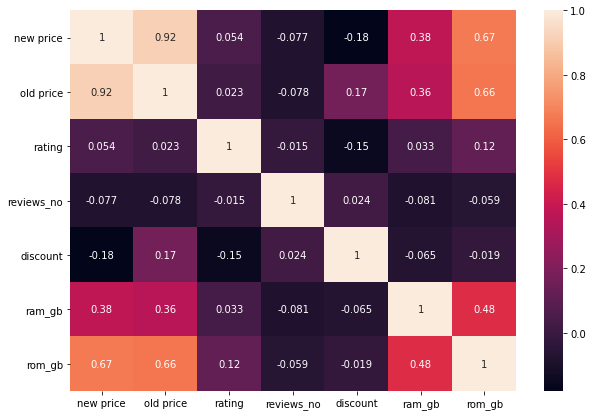

In [104]:
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(), annot=True)

### Number of brands

In [105]:
num_of_brands = len(list(set(df['brand'])))
print(f'{num_of_brands} brands exist')

53 brands exist


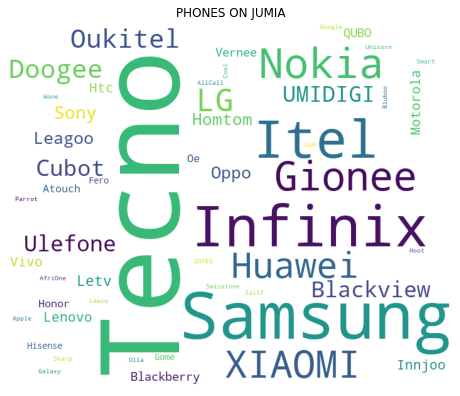

In [106]:
plt.subplots(figsize = (8,8))

wordcloud = WordCloud (max_font_size=175, background_color = 'white', width = 712, height = 584).generate(' '.join(df['brand']))
plt.imshow(wordcloud) # image show
plt.axis('off') # to off the axis of x and y
# plt.savefig('Plotly-World_Cloud.png')
plt.title('PHONES ON JUMIA')
plt.show()

#### TOP 10 BRANDS WITH THE MOST PHONES

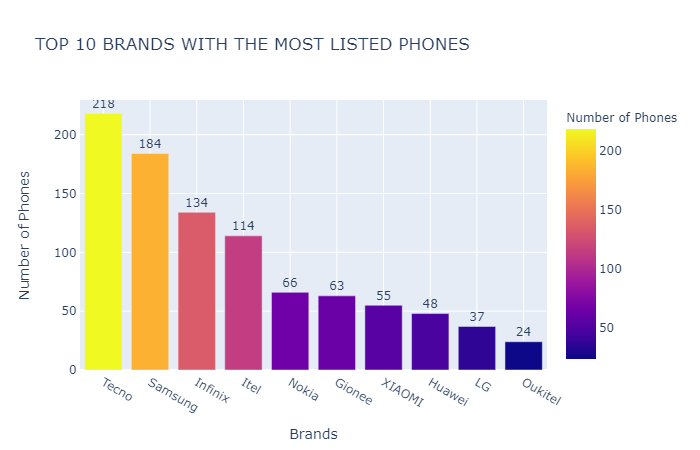

In [109]:
brand_count = df['brand'].value_counts().head(10)
all_brands = pd.DataFrame(brand_count)
all_brands.reset_index(inplace=True)
all_brands.columns = ['brand', 'count']
fig = px.bar(all_brands, x='brand', y='count', text='count', color='count',
             labels={'brand':'Brands', 'count':'Number of Phones'}, 
            title="TOP 10 BRANDS WITH THE MOST LISTED PHONES")
fig.update_traces(textposition='outside')
fig.show("png")

### MOST EXPENSIVE BRAND

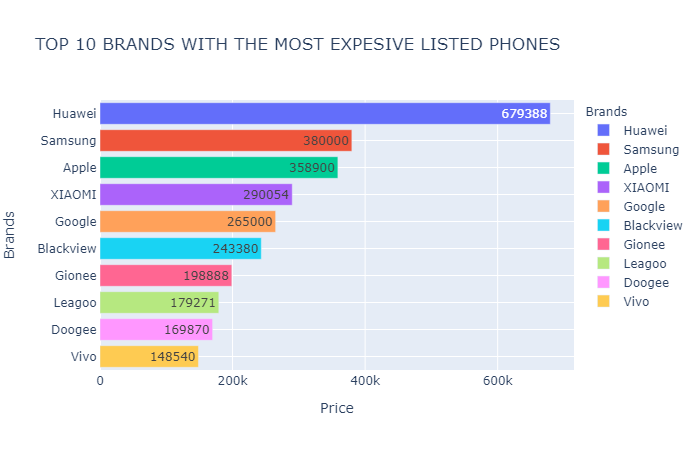

In [110]:
# most expensive brand
exp_brand = df.groupby('brand')['new price'].max().sort_values(ascending = False).head(10)
exp_brand = pd.DataFrame(exp_brand)
exp_brand.reset_index(inplace=True)
exp_brand.columns = ['brand', 'new price']

fig = px.bar(exp_brand, y='brand', x='new price', text='new price', color='brand',
             labels={'brand':'Brands', 'new price':'Price'}, 
            title="TOP 10 BRANDS WITH THE MOST EXPESIVE LISTED PHONES")
fig.show("png")

### Top 10 prominent brands based on the number of times reviewed

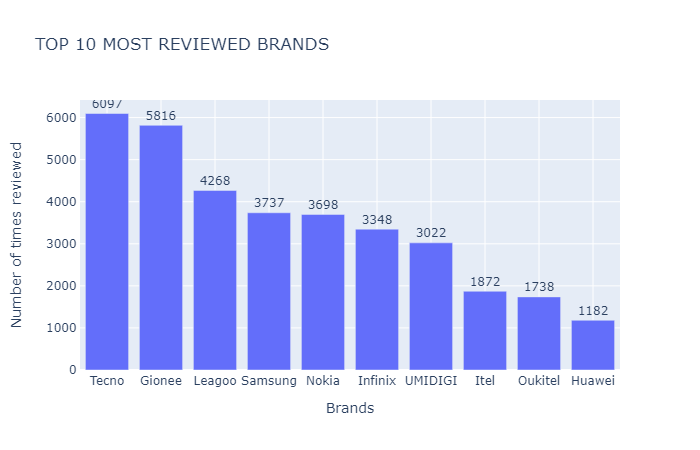

In [111]:
num_times_reviewed = df.groupby(['brand'])['reviews_no'].sum().sort_values(ascending = False).head(10)
num_times_reviewed_df = pd.DataFrame(num_times_reviewed)
num_times_reviewed_df.reset_index(inplace=True)
num_times_reviewed_df.columns = ['Brand', 'Number of times reviewed']
fig = px.bar(num_times_reviewed_df, x='Brand', y='Number of times reviewed', text='Number of times reviewed',
             labels={'Brand':'Brands', 'Number of times reviewed':'Number of times reviewed'}, 
            title='TOP 10 MOST REVIEWED BRANDS')
fig.update_traces(texttemplate='%{text}', textposition='outside')
fig.show("png")

### AVERAGE PRICE OF MOST LISTED BRANDS

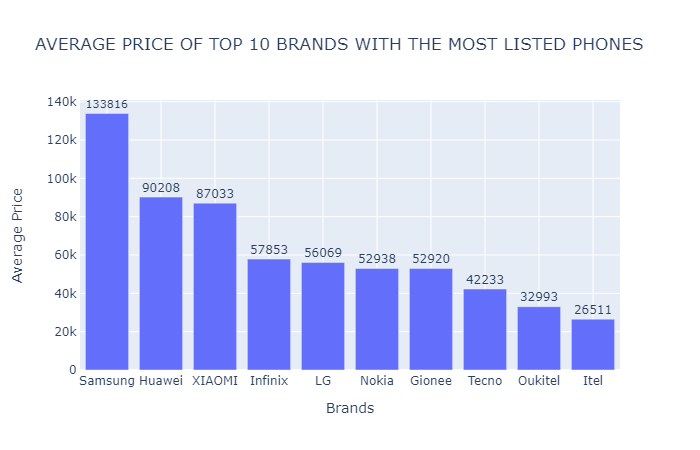

In [113]:
avg_price_brand = round(df1.groupby(['Brands'])['Average price'].mean()).sort_values(ascending = False).head(10)
avg_price_brand_df = pd.DataFrame(avg_price_brand)
avg_price_brand_df.reset_index(inplace=True)
avg_price_brand_df.columns = ['Brand','Average Price']
fig = px.bar(avg_price_brand_df, x='Brand', y='Average Price', text='Average Price',
             labels={'Brand':'Brands', 'Average price':'Average price'}, 
            title='AVERAGE PRICE OF TOP 10 BRANDS WITH THE MOST LISTED PHONES')
fig.update_traces(textposition='outside')
fig.show("png")

## CONCLUSION

In [57]:
avg_rating = round(df.groupby('brand')['rating'].mean())
avg_price_brand = round(df.groupby('brand')['new price'].mean())
avg_rom = round(df.groupby('brand')['rom_gb'].median())
avg_ram = round(df.groupby('brand')['ram_gb'].median())
brand_count = df['brand'].value_counts()

In [58]:
df1 = pd.DataFrame({'Brands':['Tecno','Samsung','Infinix','Itel','Nokia','Gionee','XIAOMI','Huawei','LG','Oukitel'],
                    
                    'Brand count':[brand_count['Tecno'],brand_count['Samsung'],brand_count['Infinix'],brand_count['Itel'],
                                  brand_count['Nokia'],brand_count['Gionee'],brand_count['XIAOMI'],brand_count['Huawei'],
                                  brand_count['LG'],brand_count['Oukitel']],
                    
                    'Average rating':[avg_rating['Tecno'],avg_rating['Samsung'],avg_rating['Infinix'],avg_rating['Itel'],
                                     avg_rating['Nokia'],avg_rating['Gionee'],avg_rating['XIAOMI'],avg_rating['Huawei'],
                                     avg_rating['LG'],avg_rating['Oukitel']],
                    
                    'Average price':[avg_price_brand['Tecno'],avg_price_brand['Samsung'],avg_price_brand['Infinix'],avg_price_brand['Itel'],
                                    avg_price_brand['Nokia'],avg_price_brand['Gionee'],avg_price_brand['XIAOMI'],avg_price_brand['Huawei'],
                                    avg_price_brand['LG'],avg_price_brand['Oukitel']],
                    
                   'Average rom':[avg_rom['Tecno'],avg_rom['Samsung'],avg_rom['Infinix'],avg_rom['Itel'],
                                   avg_rom['Nokia'],avg_rom['Gionee'],avg_rom['XIAOMI'],avg_rom['Huawei'],
                                   avg_rom['LG'],avg_rom['Oukitel']],
                    
                    'Average ram': [avg_ram['Tecno'],avg_ram['Samsung'],avg_ram['Infinix'],avg_ram['Itel'],
                                   avg_ram['Nokia'],avg_ram['Gionee'],avg_ram['XIAOMI'],avg_ram['Huawei'],
                                   avg_ram['LG'],avg_ram['Oukitel']],
                   })

df1
                    

,Brands,Brand count,Average rating,Average price,Average rom,Average ram
0,Tecno,218,4.0,42233.0,16,6.0
1,Samsung,184,4.0,133816.0,64,4.0
2,Infinix,134,5.0,57853.0,32,2.0
3,Itel,114,4.0,26511.0,16,6.0
4,Nokia,66,4.0,52938.0,32,3.0
5,Gionee,63,4.0,52920.0,64,4.0
6,XIAOMI,55,5.0,87033.0,64,4.0
7,Huawei,48,4.0,90208.0,48,3.0
8,LG,37,4.0,56069.0,32,4.0
9,Oukitel,24,4.0,32993.0,32,3.0
